In [456]:
import numpy as np
import matplotlib.pyplot as plt

In [457]:
# layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

In [458]:
fv1 = .5*np.array([1,1])
fv2 = np.array([-1,1])
fv3 = np.array([-.85,0])

# make a meshgrid of x and y values
x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
cut1 = layer(pairs, fv1)
cut2 = layer(cut1, fv2)
cut = layer(cut2, fv3)
Y = cut[:,1] > .6

In [459]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


"""
To import this class into an ipynb file in the same folder:

from model import model3    
"""



class origaminetworks():
    def __init__(self, layers = 3, width = None, max_iter=1000, tol=1e-8, learning_rate=0.01, reg=10, optimizer="grad", batch_size=32, epochs=100):
        # Hyperparameters
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.reg = reg
        self.layers = layers
        self.width = width

        # Variables to store
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        self.classes = None
        self.num_classes = None
        self.y_dict = None
        self.one_hot = None
        self.fold_vectors = None
        self.cut_matrix = None
        self.expand_matrix = None
        self.b = None
        
        # Check if the model has an expand matrix
        if self.width is not None:
            self.has_expand = True
        else:
            self.has_expand = False

        # Validation variables
        self.X_val_set = None
        self.y_val_set = None
        self.class_index = []
        self.val_history = []
        self.train_history = []
        self.weights_history = []
        

    ############################## Helper Functions ###############################
    # def set_params(self, **kwargs):
    #     """
    #     Set the parameters of the model

    #     Parameters:
    #         **kwargs - The parameters to set
    #     Returns:
    #         None
    #     """
    #     # TODO: Test this function
    #     for key, value in kwargs.items():
    #         try:
    #             setattr(self, key, value)
    #         except Exception as e:
    #             print(f"Could not set {key} to {value}. Error: {e}")
    

    # def get_params(self):
    #     """
    #     Get the parameters of the model

    #     Parameters:
    #         None
    #     Returns:
    #         params (dict) - The parameters of the model
    #     """
    #     # TODO: Test this function
    #     return self.__dict__
    


    def encode_y(self, y:np.ndarray):
        """
        Encode the labels of the data.

        Parameters:
            y (n,) ndarray - The labels of the data
        Returns:
            None
        """
        # Check if the input is a list
        if isinstance(y, list):
            y = np.array(y)

        # Make sure it is a numpy array
        elif not isinstance(y, np.ndarray):
            raise ValueError("y must be a list or a numpy array")
        
        # If it is not integers, give it a dictionary
        if y.dtype != int:
            self.classes = np.unique(y)
            self.y_dict = {label: i for i, label in enumerate(np.unique(y))}

        # If it is, still make it a dictionary
        else:
            self.classes = np.arange(np.max(y)+1)
            self.y_dict = {i: i for i in self.classes}
        self.num_classes = len(self.classes)

        # Create an index array
        for i in range(self.num_classes):
            self.class_index.append(np.where(y == self.classes[i])[0])

        # Make a one hot encoding
        self.one_hot = np.zeros((self.n, self.num_classes))
        for i in range(self.n):
            self.one_hot[i, self.y_dict[y[i]]] = 1

        
    def randomize_batches(self):
        """
        Randomize the batches for stochastic gradient descent
        Parameters:
            None
        Returns:
            batches (list) - A list of batches of indices for training
        """
        # Get randomized indices and calculate the number of batches
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        num_batches = self.n // self.batch_size

        # Loop through the different batches and get the batches
        batches = [indices[i*self.batch_size:(i+1)*self.batch_size].tolist() for i in range(num_batches)]

        # Handle the remaining points
        remaining_points = indices[num_batches*self.batch_size:]
        counter = len(remaining_points)
        i = 0

        # Fill the remaining points into the batches
        while counter > 0:
            batches[i % len(batches)].append(remaining_points[i])
            i += 1
            counter -= 1

        # Return the batches
        return batches
    
    
    def fold(self, Z, n):
        # Make the scalled inner product and the mask
        scales = (Z@n)/np.dot(n, n)
        mask = scales > 1
        
        # Make the projection and flip the points that are beyond the fold (mask)
        projected = 2 * np.outer(scales, n)
        adjustment = 2*n - projected
        return Z + mask[:,np.newaxis] * adjustment
    
    def derivative_fold(self, Z, n):
        # Get the scaled inner product, mask, and make the identity stack
        n_normal = n / np.dot(n,n)
        scales = Z@n_normal
        mask = scales > 1
        identity_stack = np.stack([np.eye(self.width) for _ in range(len(Z))])
        
        # Calculate the first component and a helper term
        first_component = (1 - scales[:,np.newaxis, np.newaxis]) * identity_stack
        helper = 2*Z @ n_normal
        
        # Calculate the outer product of n and helper, then subtract the input
        outer_product = np.outer(helper, n_normal) - Z
        second_component = np.einsum('ij,k->ikj', outer_product, n_normal)
        
        # Return the derivative
        return 2 * mask[:,np.newaxis, np.newaxis] * (first_component + second_component)
    
    
    ############################## Training Calculations ##############################
    def forward_pass(self, D:np.ndarray):
        """
        Perform a forward pass of the data through the model

        Parameters:
            D (n,d) ndarray - The data to pass through the model"""
        # Expand to a higher dimension if necessary
        if self.has_expand:
            Z = D @ self.expand_matrix.T
            output = [D, Z]
            input = Z
        
        # If there is no expand matrix, just use the data
        else:
            output = [D]
            input = D
        
        # Loop through the different layers and fold the data
        for i in range(self.layers):
            folded = self.fold(input, self.fold_vectors[i])
            output.append(folded)
            input = folded
        
        # make the final cut with the softmax
        cut = input @ self.cut_matrix.T + self.b[np.newaxis,:]
        exponential = np.exp(cut)
        softmax = exponential / np.sum(exponential, axis=1, keepdims=True)
        output.append(softmax)

        # Return the output
        return output
    
    def back_propagation(self, indices:np.ndarray):
        """
        Perform a back propagation of the data through the model

        Parameters:
            indices (ndarray) - The indices of the data to back propagate
        Returns:
            gradient list - The gradient of the model (ndarrays)
        """
        # Get the correct one hot encoding and the correct data and initialize the gradient
        D = self.X[indices]
        one_hot = self.one_hot[indices]
        gradient = []
        
        # Run the forward pass and get the softmax and outer layer
        forward = self.forward_pass(D)
        softmax = forward[-1]
        outer_layer = softmax - one_hot
        
        # Make the b and W gradient and append them to the gradient
        dW = np.einsum('ik,id->kd', outer_layer, forward[-2])
        db = np.sum(outer_layer, axis=0)
        gradient.append(dW)
        gradient.append(db)
        
        # Calculate the gradients of each fold using the forward propogation
        fold_grads = [self.derivative_fold(forward[i], self.fold_vectors[i]) for i in range(self.layers)]
        
        # Perform the back propogation for the folds
        backprop_start = outer_layer @ self.cut_matrix
        for i in range(self.layers):
            backprop_start = np.einsum('ij,ijk->ik', backprop_start, fold_grads[-i-1])
            gradient.append(np.sum(backprop_start, axis=0))
            
        # Return the gradient
        return gradient
        
        
    
    ########################## Optimization and Training Functions ############################
    def gradient_descent(self):
        """
        Perform gradient descent on the model
        Parameters:
            None
        Returns:
            None
        """
        # show_iter = max(self.max_iter,100) // 100
        for i in range(self.max_iter):
            # Get the gradient
            gradient = self.back_propagation(np.arange(self.n))
            
            # Clip any gradients that are too large
            max_norm = 5.0
            for g in gradient:
                np.clip(g, -max_norm, max_norm, out=g)

            # Update the weights of the cut matrix and the cut biases
            self.cut_matrix -= self.learning_rate * gradient[0]
            self.b -= self.learning_rate * gradient[1]

            # Update the fold vectors
            for i in range(self.layers):
                self.fold_vectors[i] -= self.learning_rate * gradient[i+2]
                
                
                ### DELETE THIS LATER ###
                # if np.sum(gradient[i+2]) != 0:
                #     raise ValueError(f"Iteration {i}, Fold Vectors Gradient: {gradient[2:]}")
                

            # # If there is a validation set, check the validation error
            # if self.X_val_set is not None and self.y_val_set is not None:
                
            #     # Predict on the validation set and append the history
            #     val_predictions = self.predict(self.X_val_set)
            #     val_accuracy = accuracy_score(self.y_val_set, val_predictions)
            #     self.val_history.append(val_accuracy)

            #     # Predict on the training set and append the history
            #     train_predictions = self.predict(self.X)
            #     train_accuracy = accuracy_score(self.y, train_predictions)
            #     self.train_history.append(train_accuracy)
                
            #     # Show the progress
            #     if i % show_iter == 0:
            #         print(f"({i}) Val Accuracy: {np.round(val_accuracy,5)}.   Train Accuracy: {train_accuracy}")


    def stochastic_gradient_descent(self, re_randomize=True):
        """
        Perform stochastic gradient descent on the model

        Parameters:
            re_randomize (bool) - Whether to re-randomize the batches after each epoch
        Returns:
            None
        """
        # Raise an error if there are no epochs or batch size, or if batch size is greater than the number of points
        if self.batch_size is None or self.epochs is None:
            raise ValueError("Batch size or epochs must be specified")
        if self.batch_size > self.n:
            raise ValueError("Batch size must be less than the number of points")
        
        # Initialize the loop, get the batches, and go through the epochs
        batches = self.randomize_batches()
        loop = tqdm(total=self.epochs*len(batches), position=0)
        self.update_differences(self.X, batches)
        for epoch in range(self.epochs):

            # reset the batches if re_randomize is true
            if re_randomize and epoch > 0:
                batches = self.randomize_batches()
                self.update_differences(self.X, batches)
            
            # Loop through the different batches
            loss_list = []
            self.weights_history.append(self.weights.copy())
            for i, batch in enumerate(batches):

                # Get the gradient, update weights, and append the loss
                gradient = self.gradient(self.weights, subset = batch, subset_num = i)
                self.weights -= self.learning_rate * gradient
                loss_list.append(self.loss(self.weights, subset = batch, subset_num = i))

                # update our loop
                loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss_list[-1]))
                loop.update()

            # If there is a validation set, check the validation error
            if self.X_val_set is not None and self.y_val_set is not None:
                
                # Predict on the validation set and append the history
                val_predictions = self.predict(self.X_val_set)
                val_accuracy = accuracy_score(self.y_val_set, val_predictions)
                self.val_history.append(val_accuracy)

                # Predict on the training set and append the history
                train_predictions = self.predict(self.X)
                train_accuracy = accuracy_score(self.y, train_predictions)
                self.train_history.append(train_accuracy)
                
                # Show the progress
                # print(f"({epoch}) Val Accuracy: {np.round(val_accuracy,5)}.   Train Accuracy: {train_accuracy}")

            # Append the history of the weights
            self.weights_history.append(self.weights.copy())
            
        # Close the loop
        loop.close()


    def fit(self, X:np.ndarray, y:np.ndarray, X_val_set=None, y_val_set=None):
        """
        Fit the model to the data

        Parameters:
            X (n,d) ndarray - The data to fit the model on
            y (n,) ndarray - The labels of the data
            X_val_set (n_val,d) ndarray - The validation set for the data
            y_val_set (n_val,) ndarray - The validation labels for the data
        Returns:
            train_history (list) - A list of training accuracies
            val_history (list) - A list of validation accuracies
        """
        # Save the data as variables and encode y
        self.X = np.array(X)
        self.y = np.array(y)
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.encode_y(y)

        # Initialize the expand matrix if necessary
        if self.has_expand:
            self.expand_matrix = np.random.randn(self.d, self.width)
        else:
            self.width = self.d
            
        # Initialize the cut matrix, fold vectors, and b
        self.cut_matrix = np.random.randn(self.num_classes, self.width)
        self.fold_vectors = .1 * np.random.randn(self.layers, self.width)
        self.b = np.random.rand(self.num_classes)

        # If there is a validation set, save it
        if X_val_set is not None and y_val_set is not None:
            self.X_val_set = X_val_set
            self.y_val_set = y_val_set

        # Run the optimizer
        if self.optimizer == "sgd":
            raise ValueError("Stochastic Gradient Descent is not implemented yet")
            self.stochastic_gradient_descent()
        elif self.optimizer == "grad":
            self.gradient_descent()

        # Otherwise, raise an error
        else:
            raise ValueError("Optimizer must be 'sgd' or 'grad'")
        
        # return self.train_history, self.val_history


    ############################## Prediction Functions #############################
    def predict(self, points:np.ndarray, show_probabilities=False):
        """
        Predict the labels of the data

        Parameters:
            points (n,d) ndarray - The data to predict the labels of
            show_probabilities (bool) - Whether to show the probabilities of the classes
        Returns:
            predictions (n,) ndarray - The predicted labels of the data
        """
        # Get the probabilities of the classes
        probabilities = self.forward_pass(points)[-1]
        
        # Get the predictions
        predictions = np.argmax(probabilities, axis=1)
        
        # Get the dictionary of the predictions
        predictions = np.array([self.classes[prediction] for prediction in predictions])
        
        # Return the predictions
        if show_probabilities:
            return probabilities
        else:
            return predictions
    

    # def score(self, X:np.ndarray=None, y:np.ndarray=None):
    #     """
    #     Get the accuracy of the model on the data
        
    #     Parameters:
    #         X (n,d) ndarray - The data to score the model on
    #         y (n,) ndarray - The labels of the data
    #     Returns:
    #         accuracy (float) - The accuracy of the model on the data
    #     """
    #     # If the data is not provided, use the training data
    #     if X is None:
    #         X = self.X
    #         y = self.y

    #     # TODO: Test this function
    #     # Get the predictions and return the accuracy
    #     predictions = self.predict(X)
    #     return accuracy_score(y, predictions)
    

    # def cross_val_score(self, X:np.ndarray, y:np.ndarray, cv=5):
    #     """
    #     Get the cross validated accuracy of the model on the data
        
    #     Parameters:
    #         X (n,d) ndarray - The data to score the model on
    #         y (n,) ndarray - The labels of the data
    #         cv (int) - The number of cross validation splits
    #     Returns:
    #         scores (list) - The accuracy of the model on the data for each split
    #     """
    #     #TODO: Test this function
    #     # Split the data and initialize the scores
    #     scores = []
    #     for train_index, test_index in train_test_split(np.arange(X.shape[0]), test_size=1/cv):
    #         X_train, X_test = X[train_index], X[test_index]
    #         y_train, y_test = y[train_index], y[test_index]

    #         # Fit the model and get the score
    #         self.fit(X_train, y_train)
    #         scores.append(self.score(X_test, y_test))
        
    #     # Return the scores
    #     return scores
    

    # def confusion_matrix(self, X:np.ndarray=None, y:np.ndarray=None):
    #     """
    #     Get the confusion matrix of the model on the data
        
    #     Parameters:
    #         X (n,d) ndarray - The data to get the confusion matrix for
    #         y (n,) ndarray - The labels of the data
    #     Returns:
    #         confusion_matrix (num_classes,num_classes) ndarray - The confusion matrix of the model
    #     """
    #     #TODO: Test this function
    #     # If the data is not provided, use the training data
    #     if X is None:
    #         X = self.X
    #         y = self.y

    #     # Get the predictions and return the confusion matrix
    #     predictions = self.predict(X)
    #     return confusion_matrix(y, predictions, labels=self.classes)


    ############################## Other Functions ###############################
    def copy(self):
        """
        Create a copy of the model

        Parameters:
            None
        Returns:
            new_model (model3 class) - A copy of the model
        """
        # Initialize a new model
        new_model = origaminetworks(max_iter=self.max_iter, tol=self.tol, learning_rate=self.learning_rate, reg=self.reg, optimizer=self.optimizer, batch_size=self.batch_size, epochs=self.epochs)
        
        # Copy the necessary attributes
        pass
        
        return new_model
    

    def save_weights(self, file_path:str, save_type="standard"):
        """
        Save the weights of the model to a file so that it can be loaded later

        Parameters:
            file_path (str) - The name of the file to save the weights to
            save_type (str) - How much of the model to save
                "full" - Save the full model and all of its attributes
                "standard" - Save the standard attributes of the model
                "weights" - Save only the weights of the model
        Returns:
            None
        """
        # TODO: Test this function
        if save_type not in ["full", "standard", "weights"]:
            raise ValueError("save_type must be 'full', 'standard', or 'weights'")
        
        preferences = {"weights": self.weights,
                       "save_type": save_type}
        if save_type == "standard":
            standar_preferences = {"max_iter": self.max_iter, 
                        "tol": self.tol, 
                        "learning_rate": self.learning_rate,
                        "optimizer": self.optimizer,
                        "batch_size": self.batch_size,
                        "epochs": self.epochs,
                        "reg": self.reg,
                        "dim_reg": self.dim_reg, 
                        "n": self.n,
                        "d": self.d,
                        "classes": self.classes,
                        "num_classes": self.num_classes,
                        "y_dict": self.y_dict,
                        "one_hot": self.one_hot,
                        }
            preferences.update(standar_preferences)
        
        if save_type == "full":
            remaining_attributes = {"X": self.X,
                                    "y": self.y,
                                    "differences": self.differences,
                                    "cur_gaussian": self.cur_gaussian,
                                    "cur_tensor_prod": self.cur_tensor_prod,
                                    "subset_differences": self.subset_differences,
                                    "X_val_set": self.X_val_set,
                                    "y_val_set": self.y_val_set,
                                    "class_index": self.class_index,
                                    "val_history": self.val_history,
                                    "train_history": self.train_history,
                                    "weights_history": self.weights_history,
                                    }
            preferences.update(remaining_attributes)

        try:
            with open(f'{file_path}.pkl', 'wb') as f:
                pickle.dump(preferences, f)
        except Exception as e:
            print(e)
            raise ValueError(f"The file '{file_path}.pkl' could not be saved.")
    

    def load_weights(self, file_path):
        """
        Load the weights of the model from a file

        Parameters:
            file_path (str) - The name of the file to load the weights from
        Returns:
            None
        """
        # TODO: Test this function
        try:
            with open(f'{file_path}.pkl', 'rb') as f:
                data = pickle.load(f)
            save_type = data["save_type"]

            self.weights = data["weights"]
            if save_type == "standard" or save_type == "full":
                self.max_iter = data["max_iter"]
                self.tol = data["tol"]
                self.learning_rate = data["learning_rate"]
                self.optimizer = data["optimizer"]
                self.batch_size = data["batch_size"]
                self.epochs = data["epochs"]
                self.reg = data["reg"]
                self.dim_reg = data["dim_reg"]
                self.n = data["n"]
                self.d = data["d"]
                self.classes = data["classes"]
                self.num_classes = data["num_classes"]
                self.y_dict = data["y_dict"]
                self.one_hot = data["one_hot"]
            if save_type == "full":
                self.X = data["X"]
                self.y = data["y"]
                self.differences = data["differences"]
                self.cur_gaussian = data["cur_gaussian"]
                self.cur_tensor_prod = data["cur_tensor_prod"]
                self.subset_differences = data["subset_differences"]
                self.X_val_set = data["X_val_set"]
                self.y_val_set = data["y_val_set"]
                self.class_index = data["class_index"]
                self.val_history = data["val_history"]
                self.train_history = data["train_history"]
                self.weights_history = data["weights_history"]

        except Exception as e:
            print(e)
            raise ValueError(f"The file '{file_path}.pkl' could not be loaded")
        

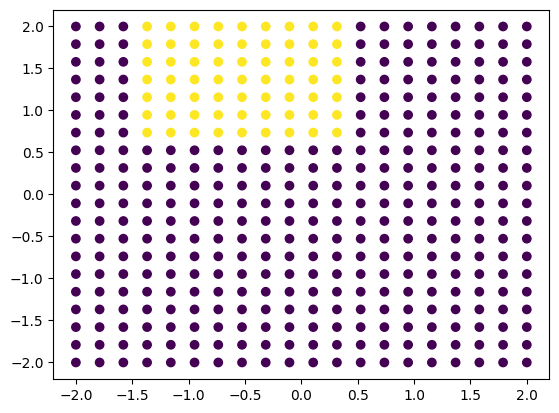

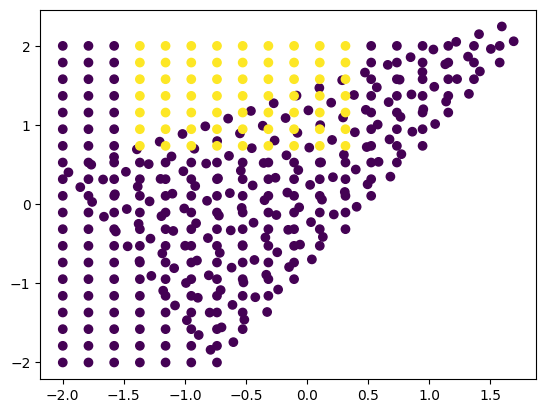

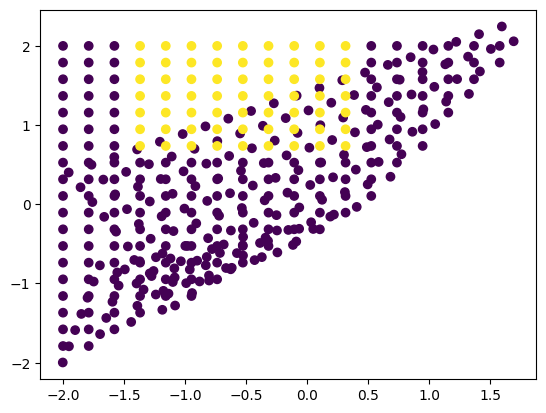

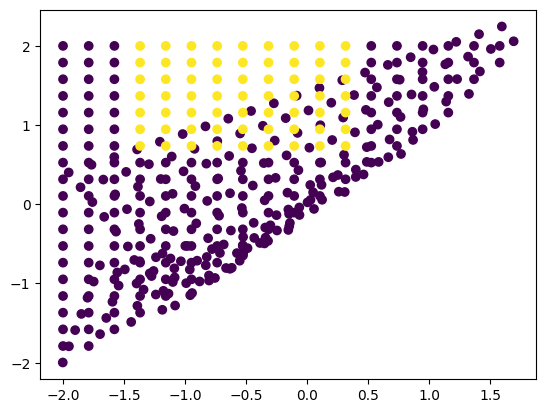

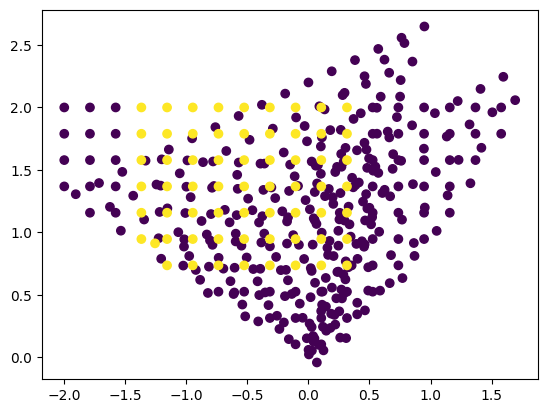

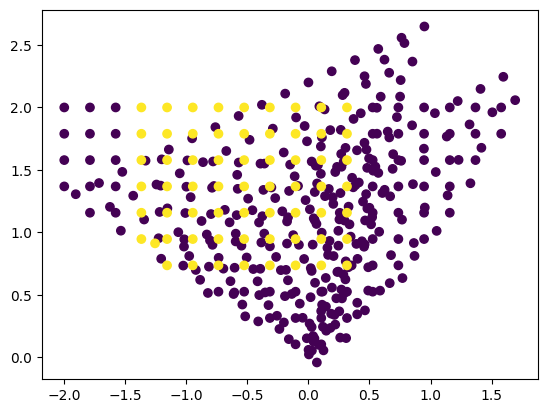

In [460]:
test = origaminetworks(layers = 5, max_iter=10000, learning_rate=0.01, optimizer="grad", batch_size=32, epochs=100)
test.fit(pairs,Y)
out = test.forward_pass(pairs)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = Y)
    plt.show()

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

In [461]:
np.array([[1,2,3],[4,5,6],[7,8,9]])[np.array([0,2,2])]

array([[1, 2, 3],
       [7, 8, 9],
       [7, 8, 9]])

In [462]:
# Test case
Z = np.array([[1, 2, 3], [4, 5, 6]])
n = np.array([1, -1/2, 1])
width = len(n)

def derivative_fold(Z, n):
    # Get the scaled inner product, mask, and make the identity stack
    n_normal = n / np.dot(n,n)
    scales = Z@n_normal
    mask = scales > 1
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    
    # Calculate the first component and a helper term
    first_component = (1 - scales[:,np.newaxis, np.newaxis]) * identity_stack
    helper = 2*Z @ n_normal
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(helper, n_normal) - Z
    second_component = np.einsum('ij,k->ikj', outer_product, n_normal)
    
    # Return the derivative
    return 2 * mask[:,np.newaxis, np.newaxis] * (first_component + second_component)


result = derivative_fold(Z, n)
print(result)


[[[-0.50205761 -2.30452675 -1.61316872]
  [-0.08230453  0.48559671  0.80658436]
  [ 0.16460905 -2.30452675 -2.27983539]]

 [[-5.58847737 -5.76131687 -2.69958848]
  [ 0.46090535 -1.78600823  1.34979424]
  [-0.9218107  -5.76131687 -7.36625514]]]


In [463]:
x = np.array([1,2,3])
n = np.array([1,-1/2,1])
n_normal = n / np.dot(n,n)

first_comp = np.eye(3)*(1 - x@n_normal)

helper = 2*(x@n_normal)
inner = helper * n_normal - x
second_comp = np.outer(n_normal, inner)
print(2*(first_comp + second_comp))

[[-0.50205761 -2.30452675 -1.61316872]
 [-0.08230453  0.48559671  0.80658436]
 [ 0.16460905 -2.30452675 -2.27983539]]


[[-0.00623979  0.00353291]
 [ 0.0050171   0.00228604]
 [ 0.10684126  0.04354755]
 [ 0.0688544   0.03230523]]


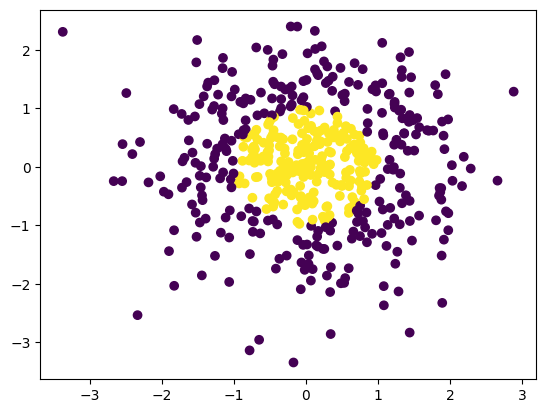

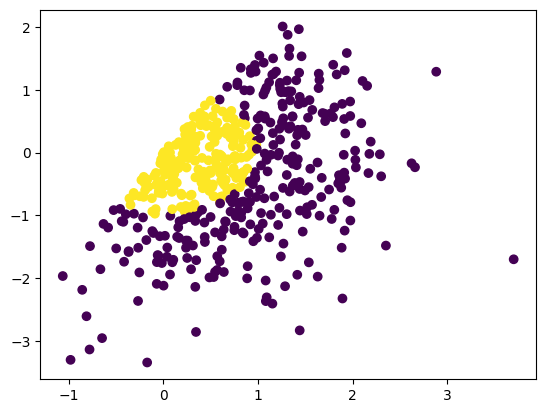

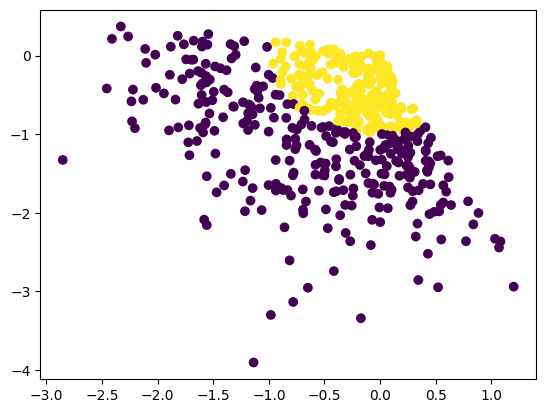

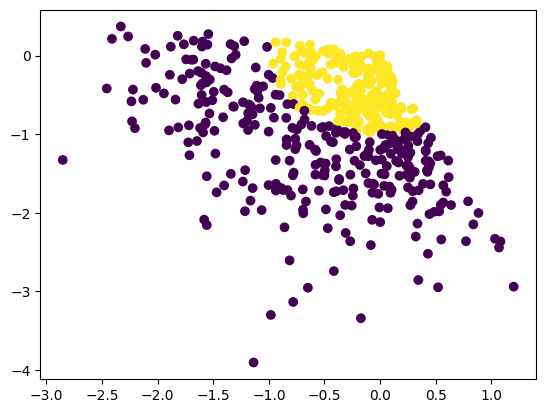

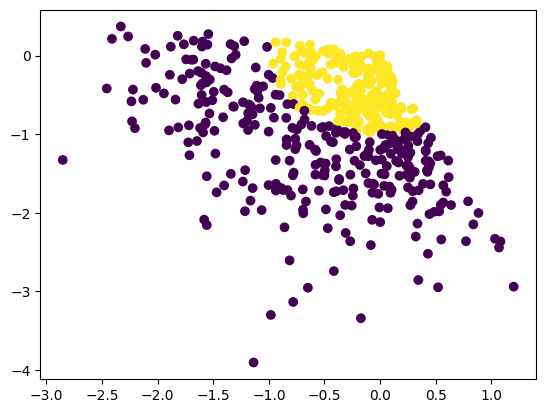

In [464]:
# Set up the model
layers = 4
width = 2
model = origaminetworks(layers=layers, max_iter=10000, learning_rate=0.001)

# Create some dummy data
X = np.random.randn(500, width)
y = np.linalg.norm(X, axis=1) < 1

# # plot the data
# plt.scatter(X[:,0], X[:,1], c=y)
# plt.show()

# Set model parameters
model.fit(X, y)
print(model.fold_vectors)


out = model.forward_pass(X)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = y)
    plt.show()
    

In [465]:
y_hat = model.predict(X)

from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_hat))




0.896


In [471]:
# import small digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# set up the model
model = origaminetworks(layers=3, max_iter=1000, learning_rate=0.001)
model.fit(X_train, y_train)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))



0.9305555555555556
